In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from acstools import acszpt
from XRBID.AutoPhots import RunPhots, DaoFindObjects

from astropy.io import fits

import glob
import shutil
import os
cd = os.chdir

# define directories to handle data in
hstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/"
chandradir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra/"
jwstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/"

f200w = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f200w_v1p1_img.fits"
f300m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f300m_v1p1_img.fits"
f335m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f335m_v1p1_img.fits"
f360m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f360m_v1p1_img.fits"

# Adapting `RunPhots` for JWST

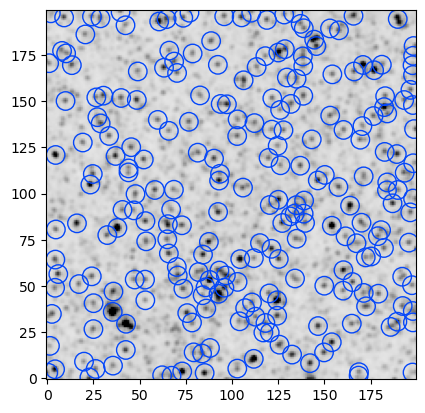

In [4]:
from XRBID.AutoPhots import DaoFindObjects
    

data = fits.getdata(f200w)
data = data[3200:3400, 3200:3400]
objects = DaoFindObjects(data, fwhm=0.14, pixtoarcs=0.031, vmax=10, plot=True)

In [93]:
from photutils.aperture import aperture_photometry, CircularAperture
from photutils.utils import calc_total_error

def perform_photometry(data_sub, data, hdu, apertures, instrument, filter, type, gal, suffix="", calc_error=True, savefile=True):
    '''
    A helper function to calculate the aperture photometry.
	
	PARAMETERS
	----------
	data_sub  [nd.array] : Background subtracted data
	apertures      [int] : the aperture size passed for performing the aperture photometry
	type           [str] : the type of photometry being performed -- full, extended or source
	savefile      [bool] (True): Save the outputs from aperture photometry
	
    RETURNS
	-------
	photometry   [array] : The photometric information of the sources. 
	
	OTHER PRODUCTS
	-------------------
    Region file for all daofind sources in the field in fk5 coordinates.
        photometry_[GALAXY]_[FILTER]_[INSTRUMENT]_full[SUFFIX].ecsv: 
    Datafile containing the full 1-30 pixel aperture photometry of all sources in the field
        photometry_[GALAXY]_[FILTER]_[INSTRUMENT]_sources[SUFFIX].ecsv: 
    Datafile containing the 3 pixel aperture photometry of all sources in the field
        photometry_[GALAXY]_[FILTER]_[INSTRUMENT]_extended[SUFFIX].ecsv: 
    Datafile containing the extended pixel aperture photometry of all sources in the field
    '''
    hst_instrument = ['acs', 'wfc3']
    if calc_error:  # If error needs to be calculated (this is mainly for extended and source photometry)
        # If hst instrument
        if instrument in hst_instrument: 
            photometry = aperture_photometry(data_sub, apertures, error=calc_total_error(data, \
                            data-data_sub, effective_gain=hdu[0].header["EXPTIME"]))
            
        else: # If jwst instrument
                photometry = aperture_photometry(data_sub, apertures, error=calc_total_error(data, \
                            data-data_sub, effective_gain=hdu[1].header["XPOSURE"]))

    else: # if you dont need to calculate error
            photometry = aperture_photometry(data_sub, apertures, method='center')

    if savefile:
        photometry.write("photometry_"+gal+"_"+filter.lower()+"_"+instrument.lower()+"_"+type+suffix+".ecsv", overwrite=True)
        print("photometry_"+gal+"_"+filter.lower()+"_"+instrument.lower()+"_"+type+suffix+".ecsv", "saved")
         
    return photometry

# Create Apertures
def create_apertures(positions, rad_list=(1, 31)):
    ap_rads = [i for i in range(1,31)]
    apertures_full = [CircularAperture(positions, r=r) for r in ap_rads]
    apertures_source = CircularAperture(positions, r=3) # 3px aperture photometry used for sources by default
    apertures_extended = CircularAperture(positions, r=10) # aperture photometry for clusters (default is 10 pixels)
    return apertures_full, apertures_source, apertures_extended


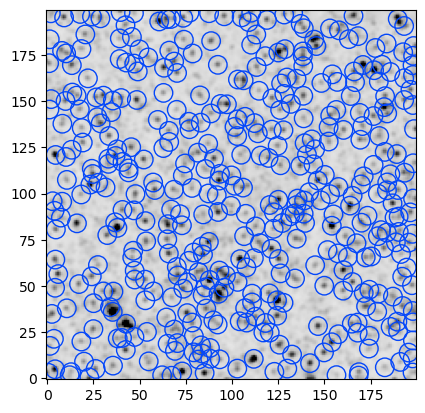

Background subtraction successful
Photometry...
photometry_M66_f200w_nircam_full.ecsv saved
photometry_M66_f200w_nircam_sources.ecsv saved
photometry_M66_f200w_nircam_extended.ecsv saved


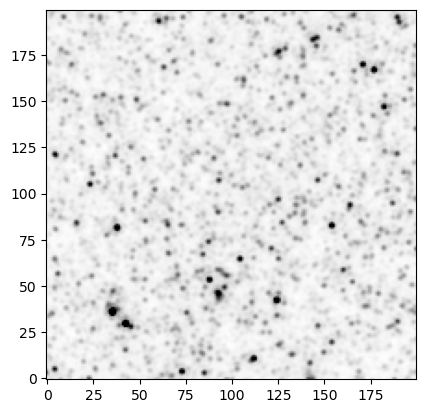

In [5]:
from XRBID.AutoPhots import DaoFindObjects, SubtractBKG, perform_photometry
from photutils.aperture import CircularAperture

min_rad=3
extended_rad=10
instrument='nircam'
gal="M66"
hdu = fits.open(f200w)
data = fits.getdata(f200w)
data = data[3200:3400, 3200:3400]
filter='F200W'

# find objects
objects = DaoFindObjects(data, sigma=5, fwhm=0.14, threshold=3, pixtoarcs=0.031, savereg=False, plot=True, vmax=10)

# subtract background
data_sub = SubtractBKG(data)
print("Background subtraction successful")
plt.imshow(data_sub, cmap='gray_r', vmax=10, origin='lower')

# Aperture Corrections
positions = np.transpose((objects['xcentroid'], objects['ycentroid']))
# Create apertures
ap_rads = [i for i in range(1,31)]
apertures_full = [CircularAperture(positions, r=r) for r in ap_rads]
apertures_source = CircularAperture(positions, r=min_rad) # 3px aperture photometry used for sources by default
apertures_extended = CircularAperture(positions, r=extended_rad) # aperture photometry for clusters (default is 10 pixels)

print("Photometry...")
# Generate aperture photometry with the background-subtracted data
# perform_photometry(data_sub, hdu, apertures, instrument, filter, type, gal, suffix="", calc_error=True, savefile=True):
phot_full = perform_photometry(data_sub, data, hdu, apertures_full, instrument=instrument, filter=filter, type='full', gal=gal, calc_error=False)
phot_sources = perform_photometry(data_sub, data, hdu, apertures_source, instrument=instrument, filter=filter, type='sources', gal=gal, calc_error=True)
phot_extended = perform_photometry(data_sub, data, hdu, apertures_extended, instrument=instrument, filter=filter, type='extended', gal=gal, calc_error=True)


In [ ]:
def create_apertures(positions, rad_list, min_rad=3, extended_rad=10):
    ''' 
    A helper function to create apertures for doing the photometry.
    
    PARAMETERS
    ----------
    positions [nd.array] : Positions of the point sources detected through the DAOFind algorithm.
    rad_list  [list] : A list of aperture radii to be used for the photometry.
    min_rad [float] (3) : Minimum radius to be used.
    max_rad [float] (10) : Maximum radius to be used for extended sources
                          (in this case, clusters)
    '''
    apertures_full = [CircularAperture(positions, r=r) for r in rad_list]
    apertures_source = CircularAperture(positions, r=min_rad) # 3px aperture photometry used for sources by default
    apertures_extended = CircularAperture(positions, r=extended_rad) # aperture photometry for clusters (default is 10 pixels)
    return apertures_full, apertures_source, apertures_extended

In [ ]:
%%time 
zeropoint = np.mean([25.55, 25.56, 25.60, 25.66])

hdu = fits.open(f200w)
RunPhots(hdu, gal='M66', fwhm_arcs=0.14, pixtoarcs=0.031, instrument='nircam', filter='F200W', zeropoint=zeropoint)

# Fixing `RunPhots` so it creates the correct region files for my use. 

Date: 21 May 2025
First, I am testing out the regions library and see if I can do anything with that. 

I am going to test the `regions` library to create a regions file for the sources detected by JWST NIRCam.

**IMPORTANT**
- A Region object can represent only one region, not an array of regions. See the workaround below

So, I could not do much with the regions library but I fixed the WriteReg bug in RunPhots. 

0.14


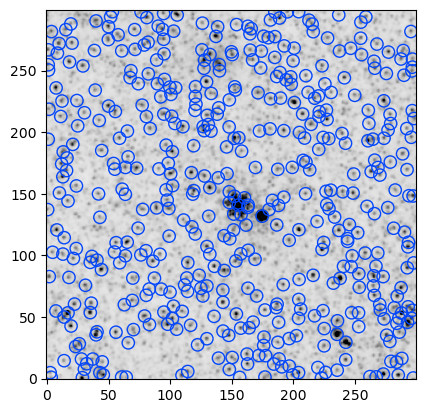

In [2]:
# I am satisfied with this configuration.

data = fits.getdata(f200w)
data = data[3200:3500, 3000:3300]
pixtoarcs = 0.031 # arcseconds for JWST Nircam short wavelength filters
fwhm = 0.14
print(fwhm)
objects = DaoFindObjects(data, fwhm=fwhm, pixtoarcs=pixtoarcs, plot=True, vmax=10)

In [54]:
# This works!!!
from regions import PixCoord, CirclePixelRegion
from regions import Regions

# Create a list of tuples of the coordinates of x and y positions
reg_list = []
for i in range(len(objects)):
    x = objects['xcentroid'][i]
    y = objects['ycentroid'][i]
    coordinate = (x, y)
    reg_list.append(coordinate)

# Create Pixel coordinates
regions = []
for x, y in reg_list:
    # print(f"x = {x} and y = {y}")
    # region = CirclePixelRegion(center=PixCoord(x, y), radius=3)
    regions.append(CirclePixelRegion(center=PixCoord(x, y), radius=3))

# Create Regions object
regs = Regions(regions)   
regs.write('test_region_img.reg', format='ds9')

# Create another fits file with the image above to test everything out
image_hdu = fits.PrimaryHDU(data=data)
hdul = fits.HDUList([image_hdu])
hdul.writeto("Test.fits")

474
Length of reg_list: 474
length of regions 474


In [73]:
# Convert pixel coordinates to fk5 
from astropy.wcs import wcs

hdulist = fits.open(f200w)
wcs = wcs.WCS(hdulist[1].header, hdulist)
hdulist.close()
regions[0].to_sky(wcs)

sky_regs = []
for i in range(len(regions)):
    sky_regs.append(regions[i].to_sky(wcs))

In [78]:
sky_regions = Regions(sky_regs)

1. astropy.io ascii
2. sublime find and replace

In [1]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from regions import PixCoord
from regions import CircleSkyRegion, CirclePixelRegion

center_sky = SkyCoord(42, 43, unit='deg', frame='fk5')
region_sky = CircleSkyRegion(center=center_sky, radius=3 * u.deg)
# region_pix = CirclePixelRegion(center=PixCoord(x=42, y=43),
#                                radius=4.2)


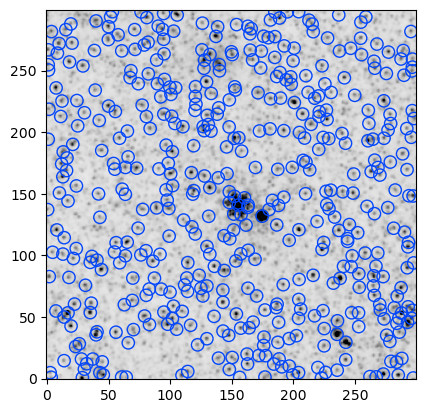


Adding [1, 1] pixel correction to x & y coordinates.
Please double-check accuracy of region file!
Saving testing_1M66_daofind_f200w_nircam_img.reg
testing_1M66_daofind_f200w_nircam_img.reg saved!


In [ ]:

from XRBID.WriteScript import WriteReg

data = fits.getdata(f200w)
data = data[3200:3500, 3000:3300]
pixtoarcs = 0.031 # arcseconds for JWST Nircam short wavelength filters
fwhm = 0.14
gal = "M66"
filter = "F200W"
instrument = "NIRCAM"
suffix = ''

reg_correction = [1, 1]

objects = DaoFindObjects(data, fwhm=fwhm, pixtoarcs=pixtoarcs, plot=True, vmax=10)

if reg_correction == False:
    xcoord_img = objects['xcentroid'].tolist()
    ycoord_img = objects['ycentroid'].tolist()
else: 
    print("\nAdding",reg_correction,"pixel correction to x & y coordinates.\nPlease double-check accuracy of region file!")
    xcoord_img = [x+reg_correction[0] for x in objects['xcentroid'].tolist()]
    ycoord_img = [y+reg_correction[1] for y in objects['ycentroid'].tolist()]

WriteReg(sources=[xcoord_img, ycoord_img], radius=3, coordsys="image", \
    	     outfile="testing_1"+gal+"_daofind_"+filter.lower()+"_"+instrument.lower()+suffix+"_img.reg", \
    	     label=objects["id"].tolist())

In [ ]:
# so this is workingz
from XRBID.WriteScript import WriteReg

objects = DaoFindObjects(data, fwhm=fwhm, pixtoarcs=pixtoarcs, plot=True, vmax=10)

if reg_correction == False:
    xcoord_img = objects['xcentroid'].tolist()
    ycoord_img = objects['ycentroid'].tolist()
else: 
    print("\nAdding",reg_correction,"pixel correction to x & y coordinates.\nPlease double-check accuracy of region file!")
    xcoord_img = [x+reg_correction[0] for x in objects['xcentroid'].tolist()]
    ycoord_img = [y+reg_correction[1] for y in objects['ycentroid'].tolist()]

WriteReg(sources=[xcoord_img, ycoord_img], radius=3, coordsys="image", \
    	     outfile="testing_1"+gal+"_daofind_"+filter.lower()+"_"+instrument.lower()+suffix+"_img.reg", \
    	     label=objects["id"].tolist())

In [ ]:
# The image file created by this code aligns pretty well with the sources detected by daofind. 
# Need to experiment with how the fk5 file is being made.
hdu = fits.open(f200w)
zeropoint = np.mean([25.55, 25.56, 25.60, 25.66])
RunPhots(hdu, gal='M66', instrument='NIRCAM', filter='F200W', fwhm_arcs=0.14,
         zeropoint=zeropoint, reg_correction=[1,1], aperture_correction=False, extended_rad=10)

In [32]:
from astropy.wcs import WCS
hdu = fits.open(f200w)
wcs = WCS(hdu['SCI'].header)
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 170.0586200432 12.982711881 
CRPIX : 3525.8943134895 4747.3553156371 
PC1_1 PC1_2  : -0.99999999899233 -4.4904054395071e-05 
PC2_1 PC2_2  : -4.4903987494157e-05 0.99999999839656 
CDELT : 8.5413754476847e-06 8.5413754476847e-06 
NAXIS : 7051  9490

In [31]:
hst = fits.open("/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66_test/HST_incomplete/M66_mosaic_acs_f814w_drc_sci.fits")
wcs = WCS(hst['PRIMARY'].header)
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 170.05904927899854 12.991740862812955 
CRPIX : 3429.0997075228083 3418.640434895877 
CD1_1 CD1_2  : -1.1005555796954e-05 2.45315463060052e-22 
CD2_1 CD2_2  : 2.14619314433631e-22 1.10055557969543e-05 
NAXIS : 6856  6836

In [4]:
from XRBID.WriteScript import WriteReg
from astropy.wcs import WCS

cd('/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/test')

data = fits.getdata(f200w)
# data = data[3200:3500, 3000:3300]
pixtoarcs = 0.031 # arcseconds for JWST Nircam short wavelength filters
fwhm = 0.14
gal = "M66"
filter = "F200W"
instrument = "NIRCAM"
suffix = ''

reg_correction = [1, 1]

objects = DaoFindObjects(data, fwhm=fwhm, pixtoarcs=pixtoarcs, plot=False, vmax=10)
hdu = fits.open(f200w)


if reg_correction == False:
    xcoord_img = objects['xcentroid'].tolist()
    ycoord_img = objects['ycentroid'].tolist()
else: 
    print("\nAdding",reg_correction,"pixel correction to x & y coordinates.\nPlease double-check accuracy of region file!")
    xcoord_img = [x+reg_correction[0] for x in objects['xcentroid'].tolist()]
    ycoord_img = [y+reg_correction[1] for y in objects['ycentroid'].tolist()]


WriteReg(sources=[xcoord_img, ycoord_img], radius=3, coordsys="image", \
    	     outfile="writereg_test1_img.reg", \
    	     label=objects["id"].tolist())

wcs = WCS(hdu['SCI'].header)
xcoords_fk5, ycoords_fk5 = wcs.wcs_pix2world(xcoord_img, ycoord_img, 1)
WriteReg(sources=[xcoords_fk5, ycoords_fk5], coordsys="fk5", \
            outfile="writereg_test1_fk5.reg", \
            radius=0.15, radunit="arcsec", label=objects["id"].tolist())


Adding [1, 1] pixel correction to x & y coordinates.
Please double-check accuracy of region file!
Saving writereg_test1_img.reg
writereg_test1_img.reg saved!
Saving writereg_test1_fk5.reg
writereg_test1_fk5.reg saved!


In [28]:
from XRBID.WriteScript import WriteReg
from astropy.wcs import WCS

cd('/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/test')

data = fits.getdata(f300m)
# data = data[3200:3500, 3000:3300]
pixtoarcs = 0.063 # arcseconds for JWST Nircam short wavelength filters
fwhm = 0.10
gal = "M66"
filter = "F300mW"
instrument = "NIRCAM"
suffix = ''

reg_correction = [1, 1]

objects = DaoFindObjects(data, fwhm=fwhm, pixtoarcs=pixtoarcs, plot=False, vmax=10)
hdu = fits.open(f300m)


if reg_correction == False:
    xcoord_img = objects['xcentroid'].tolist()
    ycoord_img = objects['ycentroid'].tolist()
else: 
    print("\nAdding",reg_correction,"pixel correction to x & y coordinates.\nPlease double-check accuracy of region file!")
    xcoord_img = [x+reg_correction[0] for x in objects['xcentroid'].tolist()]
    ycoord_img = [y+reg_correction[1] for y in objects['ycentroid'].tolist()]


WriteReg(sources=[xcoord_img, ycoord_img], radius=3, coordsys="image", \
    	     outfile="f300m_writereg_test2_img.reg", \
    	     label=objects["id"].tolist())

wcs = WCS(hdu['SCI'].header)
xcoords_fk5, ycoords_fk5 = wcs.wcs_pix2world(xcoord_img, ycoord_img, 1)
WriteReg(sources=[xcoords_fk5, ycoords_fk5], coordsys="fk5", \
            outfile="f300m_writereg_test2_fk5.reg", \
            radius=0.15, radunit="arcsec", label=objects["id"].tolist())


Adding [1, 1] pixel correction to x & y coordinates.
Please double-check accuracy of region file!
Saving f300m_writereg_test2_img.reg
f300m_writereg_test2_img.reg saved!
Saving f300m_writereg_test2_fk5.reg
f300m_writereg_test2_fk5.reg saved!


In [3]:
%%time 
zeropoint = np.mean([25.55, 25.56, 25.60, 25.66])
cd(jwstdir+'test')
hdu = fits.open(f200w)
RunPhots(hdu, gal='M66', fwhm_arcs=0.14, pixtoarcs=0.031, instrument='nircam',
         filter='F200W', zeropoint=zeropoint, num_stars=5, reg_correction=[1, 1], aperture_correction=False)

Using Zeropoint 25.5925
Using EEF: 0.925
Using pixtoarcs 0.031
Running DaoFind. This may take a while...

Adding [1, 1] pixel correction to x & y coordinates.
Please double-check accuracy of region file!
Saving M66_daofind_f200w_nircam_img.reg
M66_daofind_f200w_nircam_img.reg saved!
I am using method 2
Saving M66_daofind_f200w_nircam_fk5.reg
M66_daofind_f200w_nircam_fk5.reg saved!

 338494 sources found.
Background subtraction...
Photometry...
photometry_M66_f200w_nircam_full.ecsv saved
Time for full photometry: 2.397935231526693 minutes
Time for source photometry: 0.06573548316955566 minutes
Time for extended photometry: 0.08657071193059286 minutes
Calculating magnitudes...
photometry_M66_f200w_nircam_sources.ecsv saved
photometry_M66_f200w_nircam_extended.ecsv saved
DONE!
CPU times: user 2min 28s, sys: 19.5 s, total: 2min 48s
Wall time: 2min 53s


## Testing the identification of optical counterparts

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import glob
import shutil

from astroquery.mast import Observations
from astropy.io import fits

from XRBID.AutoPhots import RunPhots, DaoFindObjects
from XRBID.WriteScript import WriteReg
from XRBID.Sources import (LoadSources, GetCoords, GetIDs,
                           DaoClean, Crossref)
from XRBID.DataFrameMod import (RemoveElse, FindUnique, BuildFrame,
                                Find)
from XRBID.Align import CorrectAstrometry, CalcPU

from photometry_utils import instrument_info

# define directories to handle data in
cd = os.chdir
hstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/"
chandra_hst_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/"
chandra_jwst_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/"
jwstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/"

# jwst directories
f200w = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f200w_v1p1_img.fits"
f300m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f300m_v1p1_img.fits"
f335m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f335m_v1p1_img.fits"
f360m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f360m_v1p1_img.fits"

# hst directories
f275w = hstdir+"M66_mosaic_uvis_f275w_drc_sci.fits"
f336w = hstdir+"M66_mosaic_uvis_f336w_drc_sci.fits"
f438w = hstdir+"M66_mosaic_uvis_f438w_drc_sci.fits"
f555w = hstdir+"M66_mosaic_uvis_f555w_drc_sci.fits"
f814w = hstdir+"M66_mosaic_uvis_f814w_drc_sci.fits"

# Create a regions file
- create circular regions
- create text 

In [ ]:
from astropy.io import fits                     # for file handing 
from astropy.table import QTable                # for reading tables
from astropy.coordinates import SkyCoord, FK5   # for defining sky coordinates
import astropy.units as u                       # for using astronomical units (degs)
from regions import CircleSkyRegion, Regions    # for defining sky regions
from regions import TextSkyRegion               # for defining text regions

In [6]:
# Read a BinTableHDU
cluster_hdu = fits.open('/Users/undergradstudent/Downloads/ngc3627/cluster/hlsp_phangs-cat_hst_wfc3_ngc3627_multi_v1_cluster-human-class12.fits')
clustertbl = QTable(cluster_hdu[1].data)
clustertbl

INDEX,ID_PHANGS_CLUSTERS,PHANGS_X,PHANGS_Y,PHANGS_RA,PHANGS_DEC,PHANGS_CLUSTER_CLASS_HUMAN,PHANGS_CLUSTER_CLASS_ML_VGG,PHANGS_CLUSTER_CLASS_ML_VGG_QUAL,PHANGS_F275W_VEGA_TOT,PHANGS_F275W_VEGA_TOT_ERR,PHANGS_F336W_VEGA_TOT,PHANGS_F336W_VEGA_TOT_ERR,PHANGS_F438W_VEGA_TOT,PHANGS_F438W_VEGA_TOT_ERR,PHANGS_F555W_VEGA_TOT,PHANGS_F555W_VEGA_TOT_ERR,PHANGS_F814W_VEGA_TOT,PHANGS_F814W_VEGA_TOT_ERR,PHANGS_F275W_mJy_TOT,PHANGS_F275W_mJy_TOT_ERR,PHANGS_F336W_mJy_TOT,PHANGS_F336W_mJy_TOT_ERR,PHANGS_F438W_mJy_TOT,PHANGS_F438W_mJy_TOT_ERR,PHANGS_F555W_mJy_TOT,PHANGS_F555W_mJy_TOT_ERR,PHANGS_F814W_mJy_TOT,PHANGS_F814W_mJy_TOT_ERR,PHANGS_CI,PHANGS_AGE_MINCHISQ,PHANGS_AGE_MINCHISQ_ERR,PHANGS_MASS_MINCHISQ,PHANGS_MASS_MINCHISQ_ERR,PHANGS_EBV_MINCHISQ,PHANGS_EBV_MINCHISQ_ERR,PHANGS_REDUCED_MINCHISQ,NO_DETECTION_FLAG
int64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,14,6614.89,3239.51,170.06613550163783,12.939565672437887,1.0,2,0.9,20.64478245728906,0.02659657396351643,20.93979017654412,0.030188736564226437,22.250655300429276,0.031346415447021464,22.27859441730564,0.016875740045112282,22.11064764254441,0.03901893634778962,0.004894710575974825,0.00012002236400823634,0.005149012301279204,0.00014331060515183322,0.0051853476618246,0.00014985637672020489,0.004488303673158532,6.983200680382467e-05,0.003450014679669524,0.00012410973040724197,1.4406957552854887,1.0,1.0,8719.629993702069,2694.2879321260407,0.31,0.03999999999999998,0.15571900335067532,0.0
2,46,7284.4,3396.34,170.05857517129016,12.94129168906165,1.0,1,0.8,24.105332415990546,0.37037020453020186,22.714208348075548,0.08964678639377795,22.519651769070073,0.027672450452808608,21.668955157650842,0.009359068435449567,20.217371142107172,0.008528855229104975,0.0002020724158307192,6.900054767200979e-05,0.0010045155423948492,8.302346398363295e-05,0.004047429496485954,0.00010326101122819036,0.007869333245767959,6.790160231908834e-05,0.01973020252367809,0.00015514284407774865,1.6525453388887816,2440.0,1412.0,435789.158149563,132243.1815034949,0.15,0.17,0.6757897715262302,0.0
3,55,6620.99,3457.63,170.0660666598804,12.941966204158541,1.0,1,1.0,22.281918510623996,0.07737770478364059,22.22169363119243,0.0616848745282317,22.46988424208646,0.027246659028787583,22.442268805930635,0.014600834523023043,21.98812430101322,0.02959330849684471,0.001083608980805747,7.730327650696346e-05,0.0015811116822482226,8.991884008849886e-05,0.0042372716090699316,0.00010644101884595906,0.003860223743174932,5.196364647241765e-05,0.003862160160097809,0.00010537395092536263,1.5549336132831346,182.0,28.0,17467.385090088555,2360.828541606472,0.0,0.01,0.7982185920792995,0.0
4,68,6698.34,3482.21,170.06519319571672,12.942236733359024,1.0,1,1.0,20.82626233865763,0.02611063539413167,20.81526062516283,0.022289843866434313,21.009603537555332,0.010733207751301713,20.91452051154636,0.006500915802188716,20.38050871921674,0.009989056907406837,0.004141284477435931,9.969238081274846e-05,0.005774784072017913,0.00011867308687031326,0.01626292222205026,0.00016093021202070686,0.015765646894598556,9.449216496329995e-05,0.01697760840966834,0.00015635452786221064,1.7234222094582332,210.0,0.0,80145.11041876292,9281.609214165932,0.01,0.03,0.181573970260038,0.0
5,90,6745.89,3520.91,170.06465624597297,12.942662654573844,1.0,1,1.0,22.925218259744764,0.13452151333237802,22.27913233033862,0.06630949310249956,22.105464738627294,0.022063156905752657,21.881795724754113,0.012211765860952238,21.189383833152473,0.016662480049139786,0.0005991736362875742,7.431113649301165e-05,0.0014996401795385338,9.167950055632037e-05,0.005927261726618868,0.00012056776794817406,0.006468472112226721,7.282653409476053e-05,0.008059840858327328,0.00012381565857698675,1.8696595576630655,500.0,151.0,55569.664341832664,1130.107884178833,0.0,0.1,

In [ ]:
############# code for creating circular regions #############
regions = []
radius = 0.00005 * u.deg       # change this depending on the desired size of the radius
for i in range(len(clustertbl)):
    # create sky coordinates
    center_sky = SkyCoord(ra=clustertbl['PHANGS_RA'][i], dec=clustertbl['PHANGS_DEC'][i],
                          unit='deg', frame='icrs').transform_to(FK5)
    sky_reg = CircleSkyRegion(center=center_sky, radius=radius)
    regions.append(sky_reg)

regs = Regions(regions)
# regs.write("testing.reg", format='ds9')
regs

<Regions([<CircleSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (170.06614071, 12.93956223)>, radius=5e-05 deg)>, <CircleSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (170.05858038, 12.94128824)>, radius=5e-05 deg)>, <CircleSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (170.06607187, 12.94196276)>, radius=5e-05 deg)>, <CircleSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (170.06519841, 12.94223329)>, radius=5e-05 deg)>, <CircleSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (170.06466146, 12.94265921)>, radius=5e-05 deg)>, <CircleSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (170.0652489, 12.94323424)>, radius=5e-05 deg)>, <CircleSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (170.06312355, 12.94414244)>, radius=5e-05 deg)>, <CircleSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in d

In [17]:
############# code for creating textual regions #############

# Add a few degrees to the center coordinate of the source
# so that the region that is created would be above the source
clustercopy = clustertbl.copy()
clustercopy['PHANGS_DEC'] = clustercopy['PHANGS_DEC'] + 0.00005

regions = []
radius = 0.00008 * u.deg
for i in range(len(clustertbl)):
    center_sky = SkyCoord(ra=clustertbl['PHANGS_RA'][i], dec=clustercopy['PHANGS_DEC'][i],
                          unit='deg', frame='icrs').transform_to(FK5)
    sky_reg = TextSkyRegion(center=center_sky, text=clustertbl['ID_PHANGS_CLUSTERS'][i])
    regions.append(sky_reg)

regs = Regions(regions)
# regs.write("text_testing.reg", format='ds9')
regs


<Regions([<TextSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (170.06614071, 12.93961223)>, text=np.int64(14))>, <TextSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (170.05858038, 12.94133824)>, text=np.int64(46))>, <TextSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (170.06607187, 12.94201276)>, text=np.int64(55))>, <TextSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (170.06519841, 12.94228329)>, text=np.int64(68))>, <TextSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (170.06466146, 12.94270921)>, text=np.int64(90))>, <TextSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (170.0652489, 12.94328424)>, text=np.int64(112))>, <TextSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (170.06312355, 12.94419244)>, text=np.int64(148))>, <TextSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    